# Digit Recognizer

Kagggle link: https://www.kaggle.com/c/digit-recognizer


## Prepare Environment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare Data

In [2]:
all_train_data = pd.read_csv("all/train.csv")

In [3]:
# seperate train and cross from train data
train_frac = 0.9
train_data = all_train_data.sample(frac=train_frac, random_state=300)
cross_data = all_train_data.drop(train_data.index)

In [4]:
# split label and pixel
y_train = train_data['label']
X_train = train_data.drop(labels = ["label"], axis = 1) 
y_cross = cross_data['label']
X_cross = cross_data.drop(labels = ["label"], axis = 1) 

In [5]:
# normalize
X_train = X_train / 255
X_cross = X_cross / 255

In [6]:
# pandas to numpy array
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_cross = X_cross.values.reshape(-1, 28, 28, 1)

y_train = y_train.values
y_cross = y_cross.values

### Show one of example

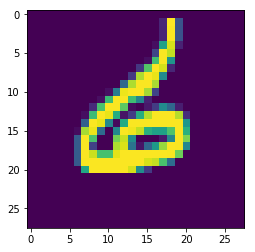

In [7]:
plt.imshow(X_train[5][:, :, 0])

## Build Model

In [8]:
def model(X, is_training):
    w_initializer = tf.variance_scaling_initializer()
    b_initializer = tf.zeros_initializer()
   
    # Convolutional Layer #1 and Pooling Layer #1
    conv1 = tf.layers.conv2d(
        inputs=X,
        filters=32,
        kernel_size=[3, 3],
        padding="valid",
        kernel_initializer=w_initializer,
        bias_initializer=b_initializer,
        activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[3, 3],
        padding="valid",
        kernel_initializer=w_initializer,
        bias_initializer=b_initializer,
        activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 64])
    dense = tf.layers.dense(
        inputs=pool2_flat, 
        units=128, 
        activation=tf.nn.relu,
        kernel_initializer=w_initializer,
        bias_initializer=b_initializer
    )
    dropout = tf.layers.dropout(inputs=dense, rate=0.6, training=is_training)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    return logits

In [9]:
# to see dimension for each layer
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.int32, [None])

# midel pipe
prediction = model(X, is_training=True)
print(str(tf.contrib.graph_editor.get_tensors(tf.get_default_graph())).replace('<', '\n<'))
    

[
<tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>, 
<tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=int32>, 
<tf.Tensor 'conv2d/kernel/Initializer/truncated_normal/shape:0' shape=(4,) dtype=int32>, 
<tf.Tensor 'conv2d/kernel/Initializer/truncated_normal/mean:0' shape=() dtype=float32>, 
<tf.Tensor 'conv2d/kernel/Initializer/truncated_normal/stddev:0' shape=() dtype=float32>, 
<tf.Tensor 'conv2d/kernel/Initializer/truncated_normal/TruncatedNormal:0' shape=(3, 3, 1, 32) dtype=float32>, 
<tf.Tensor 'conv2d/kernel/Initializer/truncated_normal/mul:0' shape=(3, 3, 1, 32) dtype=float32>, 
<tf.Tensor 'conv2d/kernel/Initializer/truncated_normal:0' shape=(3, 3, 1, 32) dtype=float32>, 
<tf.Tensor 'conv2d/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>, 
<tf.Tensor 'conv2d/kernel/Assign:0' shape=(3, 3, 1, 32) dtype=float32_ref>, 
<tf.Tensor 'conv2d/kernel/read:0' shape=(3, 3, 1, 32) dtype=float32>, 
<tf.Tensor 'conv2d/bias/Initializer/zeros:0' shape=(32,) dtype=float32>, 
<tf.Tensor 

## Build Train Process

In [16]:
def train(X_train, y_train, X_cross, y_cross, learning_rate, batch_size, epochs_num):
    train_data_num, _, _, _ = X_train.shape
    
    tf.reset_default_graph()
    
    X = tf.placeholder('float', [None, 28, 28, 1])
    y = tf.placeholder(tf.int32, [None])
    
    # model pipe
    prediction = model(X, is_training=True)
    
    # train pipe
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = prediction, labels = y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # cross validation pipe
    correct = tf.equal(tf.argmax(prediction, 1, output_type=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs_num):
        # shuffle data
        index = np.random.permutation(train_data_num)
        X_train=X_train[index]
        y_train=y_train[index]
        
        epoch_loss = 0
        for k in range(math.floor(train_data_num/batch_size)):
            mini_batch_X = X_train[k * batch_size : k * batch_size + batch_size]
            mini_batch_Y = y_train[k * batch_size : k * batch_size + batch_size]
            
            _, tc = sess.run([optimizer, cost], feed_dict={X: mini_batch_X, y: mini_batch_Y})
            epoch_loss += tc

        train_ac = sess.run(accuracy, feed_dict={X: X_train, y: y_train})
        cross_ac, cross_loss = sess.run([accuracy, cost], feed_dict={X:X_cross, y:y_cross})
        
        train_ac = train_ac*100
        cross_ac = cross_ac*100
        print('Epoch ', epoch+1 , ' / ', epochs_num, ': ')
        print('- Train loss: ', epoch_loss, ', Train ac: ', train_ac)
        print('- Cross loss: ', cross_loss, ', Cross ac: ', cross_ac)

    saver.save(sess, 'ckpt/digit_recog.ckpt')
    sess.close()
    
    return epoch_loss, train_ac, cross_loss, cross_ac

## Choose hyperparameter 

### 1. choose learning  rate

In [18]:
learning_rate = [0.001, 0.01, 0.1]
batch_size = 128
epochs_num = 10

max_cross_ac = 0
best_lr = learning_rate[0]
for lr in learning_rate:
    print('--- lr: ', lr, '---')
    train_loss, train_ac, cross_loss, cross_ac = train(X_train, y_train, X_cross, y_cross, 
                                                       lr, batch_size, epochs_num)
    if cross_ac > max_cross_ac:
        max_cross_ac = cross_ac
        best_lr = lr

print("\nBest learning rate: ", best_lr, ' with cross accuracy:', max_cross_ac)

--- lr:  0.001 ---
Epoch  1  /  10 : 
- Train loss:  118.28529321402311 , Train ac:  95.28042078018188
- Cross loss:  0.1679758 , Cross ac:  94.97619271278381
Epoch  2  /  10 : 
- Train loss:  41.300268441438675 , Train ac:  96.56878113746643
- Cross loss:  0.1160628 , Cross ac:  96.69047594070435
Epoch  3  /  10 : 
- Train loss:  30.919281600043178 , Train ac:  97.37301468849182
- Cross loss:  0.09012888 , Cross ac:  97.47619032859802
Epoch  4  /  10 : 
- Train loss:  25.093676397576928 , Train ac:  97.89153337478638
- Cross loss:  0.08245915 , Cross ac:  97.69047498703003
Epoch  5  /  10 : 
- Train loss:  21.289368056692183 , Train ac:  98.26455116271973
- Cross loss:  0.07003832 , Cross ac:  97.83333539962769
Epoch  6  /  10 : 
- Train loss:  17.92128860903904 , Train ac:  98.25661182403564
- Cross loss:  0.07498747 , Cross ac:  97.97618985176086
Epoch  7  /  10 : 
- Train loss:  16.651686898432672 , Train ac:  98.48941564559937
- Cross loss:  0.0703983 , Cross ac:  97.9761898517608

You can see the best learning rate for cross loss is **0.001** with cross accuracy: 98.04762005805969

### 2. choose batch size

In [19]:
# change batch size
learning_rate = 0.001
batch_size_list = [64, 128, 256]
epochs_num = 10

max_cross_ac = 0
best_bs = batch_size_list[0]
for bs in batch_size_list:
    print('--- batch size: ', bs, ' ---')
    train_loss, train_ac, cross_loss, cross_ac = train(X_train, y_train, X_cross, y_cross, 
                                                       learning_rate, bs, epochs_num)
    if cross_ac > max_cross_ac:
        max_cross_ac = cross_ac
        best_bs = bs

print("\nBest batch size: ", best_bs, ', with cross accuracy:', max_cross_ac)

--- batch size:  64  ---
Epoch  1  /  10 : 
- Train loss:  195.9907901994884 , Train ac:  95.96296548843384
- Cross loss:  0.13417675 , Cross ac:  95.92857360839844
Epoch  2  /  10 : 
- Train loss:  70.02418467402458 , Train ac:  97.36508131027222
- Cross loss:  0.09691779 , Cross ac:  97.09523916244507
Epoch  3  /  10 : 
- Train loss:  51.47557849064469 , Train ac:  97.8518545627594
- Cross loss:  0.07777838 , Cross ac:  97.42857217788696
Epoch  4  /  10 : 
- Train loss:  42.16823971341364 , Train ac:  97.76190519332886
- Cross loss:  0.08799585 , Cross ac:  97.57142663002014
Epoch  5  /  10 : 
- Train loss:  36.65191896818578 , Train ac:  98.38888645172119
- Cross loss:  0.07146958 , Cross ac:  98.00000190734863
Epoch  6  /  10 : 
- Train loss:  31.816332316957414 , Train ac:  98.70370626449585
- Cross loss:  0.067367174 , Cross ac:  98.04762005805969
Epoch  7  /  10 : 
- Train loss:  26.522872751695104 , Train ac:  98.68518710136414
- Cross loss:  0.0642966 , Cross ac:  98.357141017

You can see the best batch size for cross loss is **64** with cross accuracy: 98.33333492279053

(The batch size 128 is also ok with the same cross accuracy)

### 3. choose epoch num

In [45]:
learning_rate = 0.001
batch_size_list = 128
epochs_num = 20

train_loss, train_ac, cross_loss, cross_ac = train(X_train, y_train, X_cross, y_cross, 
                                                   learning_rate, bs, epochs_num)

print('\nCross accuracy:', cross_ac)


Epoch  1  /  20 : 
- Train loss:  71.58859105408192 , Train ac:  94.27777528762817
- Cross loss:  0.1959934 , Cross ac:  93.92856955528259
Epoch  2  /  20 : 
- Train loss:  22.98341851681471 , Train ac:  96.32539749145508
- Cross loss:  0.13656352 , Cross ac:  96.21428847312927
Epoch  3  /  20 : 
- Train loss:  16.658662535250187 , Train ac:  96.83068990707397
- Cross loss:  0.1174908 , Cross ac:  96.71428799629211
Epoch  4  /  20 : 
- Train loss:  13.932770788669586 , Train ac:  97.58994579315186
- Cross loss:  0.09165271 , Cross ac:  97.4047601222992
Epoch  5  /  20 : 
- Train loss:  11.701462026685476 , Train ac:  97.83597588539124
- Cross loss:  0.08339448 , Cross ac:  97.54762053489685
Epoch  6  /  20 : 
- Train loss:  10.252482263371348 , Train ac:  98.19047451019287
- Cross loss:  0.079214625 , Cross ac:  97.90475964546204
Epoch  7  /  20 : 
- Train loss:  8.836864080280066 , Train ac:  98.25661182403564
- Cross loss:  0.06418707 , Cross ac:  97.97618985176086
Epoch  8  /  20 : 

Look above loss history, maybe 13 epoches is ok for batchsize 128.

In [46]:
learning_rate = 0.001
batch_size_list = 128
epochs_num = 13

train_loss, train_ac, cross_loss, cross_ac = train(X_train, y_train, X_cross, y_cross, 
                                                   learning_rate, bs, epochs_num)

print('\nCross accuracy:', cross_ac)


Epoch  1  /  13 : 
- Train loss:  76.33140078186989 , Train ac:  94.07936334609985
- Cross loss:  0.20585127 , Cross ac:  93.92856955528259
Epoch  2  /  13 : 
- Train loss:  25.05654550343752 , Train ac:  95.67460417747498
- Cross loss:  0.14550412 , Cross ac:  95.71428298950195
Epoch  3  /  13 : 
- Train loss:  17.761835731565952 , Train ac:  96.92327976226807
- Cross loss:  0.11209433 , Cross ac:  96.83333039283752
Epoch  4  /  13 : 
- Train loss:  15.016760770231485 , Train ac:  97.4047601222992
- Cross loss:  0.09533734 , Cross ac:  97.2857117652893
Epoch  5  /  13 : 
- Train loss:  12.63373601064086 , Train ac:  97.66402244567871
- Cross loss:  0.09395744 , Cross ac:  97.35714197158813
Epoch  6  /  13 : 
- Train loss:  10.82520467042923 , Train ac:  98.0899453163147
- Cross loss:  0.072106585 , Cross ac:  97.9285717010498
Epoch  7  /  13 : 
- Train loss:  10.300339573994279 , Train ac:  98.1243371963501
- Cross loss:  0.07369041 , Cross ac:  97.64285683631897
Epoch  8  /  13 : 
- 

## Output test data

In [47]:
def predict_test_data():
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    prediction = model(X, is_training=False)
    y = tf.argmax(prediction, 1)

    saver = tf.train.Saver()
    sess= tf.Session()
    saver.restore(sess, 'ckpt/digit_recog.ckpt')
    result = sess.run(y, feed_dict={X: test_data})
    return result

In [48]:
test_data = pd.read_csv("all/test.csv")
test_data = test_data.values.reshape(-1, 28, 28, 1) / 255

In [49]:
def output_test_data(result, filename):
    # output csv
    index = [i for i in range(1, len(result)+1)]

    r = pd.DataFrame(result, index=index)
    r.columns = ['Label']
    r.to_csv(filename, index_label='ImageId')  

INFO:tensorflow:Restoring parameters from ckpt/digit_recog.ckpt
4


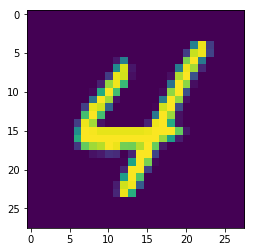

In [50]:
result = predict_test_data()

# show one of result
i = 42
print(result[i])
g = plt.imshow(test_data[i].reshape(28, 28))

In [51]:
# output
output_test_data(result, "result.csv")

## Data Argumentation

Since my best score for testdata is 0.98985 and, I want to try data argumentation.

In [52]:
from keras.preprocessing.image import ImageDataGenerator


def train_with_argumentaion(X_train, y_train, X_cross, y_cross, learning_rate, batch_size, epochs_num):
    train_data_num, _, _, _ = X_train.shape
    
    tf.reset_default_graph()
    
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    y = tf.placeholder(tf.int32, [None])
    
    # argumentaion
    datagen = ImageDataGenerator(
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1)
    
    # model pipe
    prediction = model(X, is_training=True)
    
    # train pipe
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = prediction, labels = y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # cross validation pipe
    correct = tf.equal(tf.argmax(prediction, 1, output_type=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    max_cross_ac = 0
    for epoch in range(epochs_num):
        # shuffle data
        
        epoch_loss = 0
        batch_num = 0
        batch_num_max = math.floor(train_data_num/batch_size)
        for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size):
            _, tc = sess.run([optimizer, cost], feed_dict={X: x_batch, y: y_batch})
            epoch_loss += tc
            batch_num +=1
            if batch_num >= batch_num_max:
                break

        train_ac = sess.run(accuracy, feed_dict={X: X_train, y: y_train})
        cross_ac, cross_loss = sess.run([accuracy, cost], feed_dict={X:X_cross, y:y_cross})
        
        train_ac = train_ac*100
        cross_ac = cross_ac*100
        print('Epoch ', epoch+1 , ' / ', epochs_num, ': ')
        print('- Train loss: ', epoch_loss, ', Train ac: ', train_ac)
        print('- Cross loss: ', cross_loss, ', Cross ac: ', cross_ac)

    saver.save(sess, 'ckpt/digit_recog.ckpt')
    sess.close()
    
    return epoch_loss, train_ac, cross_loss, cross_ac

Using TensorFlow backend.


In [54]:
learning_rate = 0.001
batch_size = 128
epochs_num = 13

train_loss, train_ac, cross_loss, cross_ac = train_with_argumentaion(X_train, y_train, X_cross, y_cross, 
                                                                     learning_rate, batch_size, epochs_num)


Epoch  1  /  13 : 
- Train loss:  204.4436512887478 , Train ac:  94.28571462631226
- Cross loss:  0.18660966 , Cross ac:  94.80952620506287
Epoch  2  /  13 : 
- Train loss:  89.4371302574873 , Train ac:  96.16402387619019
- Cross loss:  0.115885675 , Cross ac:  96.42857313156128
Epoch  3  /  13 : 
- Train loss:  68.7021341919899 , Train ac:  97.22751379013062
- Cross loss:  0.08891035 , Cross ac:  97.42857217788696
Epoch  4  /  13 : 
- Train loss:  56.09951478242874 , Train ac:  96.74338698387146
- Cross loss:  0.09676476 , Cross ac:  97.23809361457825
Epoch  5  /  13 : 
- Train loss:  49.5571723356843 , Train ac:  97.61375784873962
- Cross loss:  0.07357875 , Cross ac:  98.04762005805969
Epoch  6  /  13 : 
- Train loss:  45.47972438111901 , Train ac:  97.57142663002014
- Cross loss:  0.07228143 , Cross ac:  98.04762005805969
Epoch  7  /  13 : 
- Train loss:  40.96763815358281 , Train ac:  97.88095355033875
- Cross loss:  0.06333266 , Cross ac:  98.19047451019287
Epoch  8  /  13 : 
- T

INFO:tensorflow:Restoring parameters from ckpt/digit_recog.ckpt
4


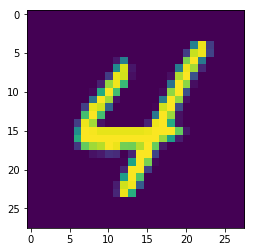

In [57]:
test_data = pd.read_csv("all/test.csv")
test_data = test_data.values.reshape(-1, 28, 28, 1) / 255


result = predict_test_data()

# show one of result
i = 42
print(result[i])
g = plt.imshow(test_data[i].reshape(28, 28))

In [58]:
# output
output_test_data(result, "result-argu.csv")

Use argumentation, the accuracy reach 0.99100!